In [1]:
# bounding box coords of the area of interest
minx = -78.250
miny = 44.775
maxx = -78.350
maxy = 44.875
# number of fishnet grids
# grid_num = 4
# CRS of HRDEM
crs = 'utm17'

In [2]:
### create shp for the bbox
import geopandas as gpd
from shapely.geometry import Polygon
%matplotlib inline

# lat lon coords of bbox in two lists
lat_point_list = [maxy,maxy,miny,miny,maxy]
lon_point_list = [minx,maxx,maxx,minx,minx]

# create shapely polygon
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       
polygon = polygon.set_crs("EPSG:4617") # NAD83 CSRS
print(polygon.geometry)

# output polygon as an Esri shapefile
polygon.to_file(filename='Data/study_area.shp', driver="ESRI Shapefile")

print ("Study area shp is created successfully!")

0    POLYGON ((-78.25000 44.87500, -78.35000 44.875...
Name: geometry, dtype: geometry
Study area shp is created successfully!


In [ ]:
### create fishnet grid for future usage
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
from math import sqrt
%matplotlib inline

length = (maxx-minx)/sqrt(grid_num)
wide = (maxy-miny)/sqrt(grid_num)

cols = list(np.arange(minx, maxx + wide, wide))
rows = list(np.arange(miny, maxy + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file('fishnet_grid.shp')

grid.plot()

print ("Fishnet grid shp is created successfully!")

Datasets Footprints are downloaded successfully!
Projects Footprints are downloaded successfully!


<AxesSubplot:>

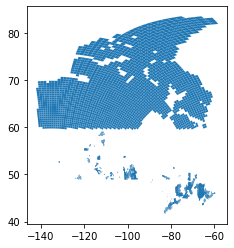

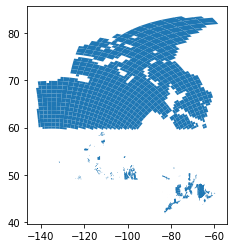

In [14]:
### download data
import requests, zipfile, json
import geopandas as gpd
%matplotlib inline

## download dataset footprint shapefile
url_df = 'https://ftp.maps.canada.ca/pub/elevation/dem_mne/highresolution_hauteresolution/Datasets_Footprints.zip'
r_df = requests.get(url_df, allow_redirects=True)
zip_df = 'Data/Datasets_Footprints.zip'
open(zip_df, 'wb').write(r_df.content)

# unzip
with zipfile.ZipFile(zip_df,"r") as zip_ref:
    zip_ref.extractall("Data")

print ("Datasets Footprints are downloaded successfully!")

## download project footprint shapefile
url_pf = 'https://ftp.maps.canada.ca/pub/elevation/dem_mne/highresolution_hauteresolution/Projects_Footprints.zip'
r_pf = requests.get(url_pf, allow_redirects=True)
zip_pf = 'Data/Projects_Footprints.zip'
open(zip_pf, 'wb').write(r_pf.content)

# unzip
with zipfile.ZipFile(zip_pf,"r") as zip_ref:
    zip_ref.extractall("Data")

print ("Projects Footprints are downloaded successfully!")

# plot
Dataset_Footprints = gpd.GeoDataFrame.from_file('Data/Datasets_Footprints.shp')
Projects_Footprints = gpd.GeoDataFrame.from_file('Data/Projects_Footprints.shp')

Dataset_Footprints.plot()
Projects_Footprints.plot()

Projects Footprints are prepared!


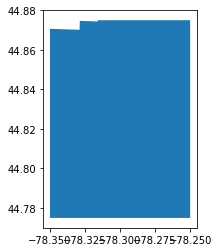

In [3]:
## clean up the project footprint shapefile a bit
# read data
Projects_Footprints = gpd.GeoDataFrame.from_file('Data/Projects_Footprints.shp')
Study_Area = gpd.GeoDataFrame.from_file('Data/study_area.shp')

# clip the project footprint to the extent of study area
Projects_Footprints_clipped = gpd.clip(Projects_Footprints, Study_Area)

# dissolve all polygons 
Projects_Footprints_clipped['dissolvefield'] = 1
Projects_Footprints_clipped = Projects_Footprints_clipped[['dissolvefield', 'geometry']]
Projects_Footprints_dissolved = Projects_Footprints_clipped.dissolve(by='dissolvefield')

# output polygon as an Esri shapefile
Projects_Footprints_dissolved.to_file(filename='Data/Projects_Footprints_dissolved.shp', driver="ESRI Shapefile")

Projects_Footprints_dissolved.plot()

print ("Projects Footprints are prepared!")

In [36]:
## download CDEM
# STAC API search endpoint
stac_cdem = "https://datacube.services.geo.ca/api/search?collections=cdem&bbox={},{},{},{}".format(minx,miny,maxx,maxy)

# POST request adding the defined payload
response_cdem = requests.request("GET", stac_cdem)

# Load response as JSON
json_object = json.loads(response_cdem.text)
print(json.dumps(json_object, indent=2))

# create empty lists to store url and file names
url_cdem_list=[]
file_cdem_list = []

# loop through the coverages returned
for f in json_object['features']:
    url_cdem_list.append(f['assets']['dem']['href'])

# fill the file name list
for i in range(1,len(url_cdem_list)+1):
    file_cdem_list.append('Data/CDEM_'+ str(i) + '.tif')

# loop through the url list and download each tiff
for url, tif in zip(url_cdem_list, file_cdem_list):
    r = requests.get(url, allow_redirects=True)
    open(tif, 'wb').write(r.content)
    print ("Download "+tif)

print ("CDEM are downloaded successfully!")

{
  "type": "FeatureCollection",
  "context": {
    "returned": 1,
    "matched": 1
  },
  "features": [
    {
      "id": "cdem-28",
      "stac_version": "1.0.0-beta.2",
      "stac_extensions": [],
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -76.85013335565041,
              39.92231365781864
            ],
            [
              -73.93870327607807,
              46.60719148103654
            ],
            [
              -84.17263730038864,
              48.38696366905439
            ],
            [
              -85.73652613731983,
              41.40594641671698
            ],
            [
              -76.85013335565041,
              39.92231365781864
            ]
          ]
        ]
      },
      "bbox": [
        -85.73652613731983,
        39.92231365781864,
        -73.93870327607807,
        48.38696366905439
      ],
      "links": [
        {
          "href": "/coll

In [4]:
## download HRDEM
# read data
Datasets_Footprints = gpd.GeoDataFrame.from_file('Data/Datasets_Footprints.shp')
Study_Area = gpd.GeoDataFrame.from_file('Data/study_area.shp')

# filter out the intersected tiles
join = gpd.sjoin(Datasets_Footprints, Study_Area, how="inner", op="intersects")
join = join[['Coord_Sys','Ftp_dtm']]
join = join[join['Coord_Sys'] == crs]

print (join.head())

# store url and file names in lists
url_hrdem_list = join['Ftp_dtm'].tolist()
file_hrdem_list = []

# fill the file name list
for i in range(1,len(url_hrdem_list)+1):
    file_hrdem_list.append('Data/HRDEM_'+ str(i) + '.tif')

# loop through the url list and download each tiff
for url, tif in zip(url_hrdem_list, file_hrdem_list):
    r = requests.get(url, allow_redirects=True)
    open(tif, 'wb').write(r.content)
    print ("Download "+tif)

print ("HRDEM are downloaded successfully!")

     Coord_Sys                                            Ftp_dtm
4895     utm17  https://ftp.maps.canada.ca/pub/elevation/dem_m...
4896     utm17  https://ftp.maps.canada.ca/pub/elevation/dem_m...
4907     utm17  https://ftp.maps.canada.ca/pub/elevation/dem_m...
4908     utm17  https://ftp.maps.canada.ca/pub/elevation/dem_m...
HRDEM are downloaded successfully!
